In [1]:
import numpy as np
import argparse
import os
import sys
import shutil

In [2]:
import lal
import lalsimulation as lalsim
from RIFT.misc.dag_utils import mkdir
import RIFT.lalsimutils as lalsimutils
from RIFT.misc.dag_utils import which
lalapps_path2cache = which('lal_path2cache')

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.6.3
  numpy :  1.20.3


In [3]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot

In [19]:
# Priors
n_events=1

mass1 = 50
mass2 = 90

# **** might need to be tweaked !!**** need a range such that waveforms appear diff
m_chirp = (mass1*mass2)**(3./5.)*(mass1+mass2)**(-1./5.)
mc_min=int(m_chirp)
mc_max= mc_min+5
mc_range = [mc_min,mc_max]
m_min=1

d_min = 3000
d_max = d_min + 100

In [20]:
eta_min=0.2
eta_max=0.249999
eta_range = [eta_min,eta_max]
ecc_min = 0.05
ecc_max = 0.3
chi_max = 1

no_spin=True
precessing_spin=False
aligned_spin=False
volumetric_spin=True
use_eccentric = False
use_matter=False

fix_sky_location=True
fix_event_time=True

fiducial_event_time=1000000000
fiducial_ra =0
fiducial_dec=0

#approx='TaylorF2'
approx='IMRPhenomXHM'
fmin_template=20

ifos = ['H1','L1', 'V1']
channels = {'H1': 'FAKE-STRAIN', 'L1':'FAKE-STRAIN','V1':'FAKE-STRAIN'}
flow= {'H1':20, 'L1':20, 'V1':20}
fmax = 2000
seglen_data = 16
seglen_analysis = 16

# for frame generation
srate_data=4096  
# for analysis
srate_analysis =4096 
use_LI_conditioning=True

In [21]:
### Create the signal parameter dictionary ###

P_list =[]; indx=0
while len(P_list) < n_events:
    P = lalsimutils.ChooseWaveformParams()
    # Randomize (sky location, etc)
    P.randomize(dMax=d_max,dMin=d_min,aligned_spin_Q=aligned_spin,volumetric_spin_prior_Q=volumetric_spin,sMax=chi_max)
    P.tref = fiducial_event_time
    P.fmin=fmin_template
    P.deltaF = 1./seglen_data
    P.deltaT = 1./srate_data
    # sky location
    if fix_sky_location:
        P.theta = fiducial_dec
        P.phi = fiducial_ra
    # some redundancy
    if no_spin:
        P.s1x=P.s1y=P.s1z=0
        P.s2x=P.s2y=P.s2z=0
    elif aligned_spin:
        P.s1x = P.s1y=0
        P.s2x = P.s2y=0
    if use_matter:
        P.lambda1 = np.random.uniform(0,lambda_max)
        P.lambda2 = np.random.uniform(0,lambda_max)
    if use_eccentric:
        P.eccentricity = np.random.uniform(ecc_min, ecc_max)
        P.fecc = 20.0
    P.approx=lalsim.GetApproximantFromString(approx)
    # Uniform in m1 and m2: 
    m1 = np.random.uniform(mc_range[0],mc_range[1]*2)
    m2 = np.random.uniform(m_min,mc_range[1]*1.5)
    m1,m2 = [np.maximum(m1,m2), np.minimum(m1,m2)]
    P.m1 = m1*lal.MSUN_SI
    P.m2 = m2*lal.MSUN_SI
    # ...but downselect in mchirp, eta
    mc_val = P.extract_param('mc')/lal.MSUN_SI
    eta_val = P.extract_param('eta')
    # Check rand vals are within specified ranges after converting inputs
    if mc_val < mc_range[0] or mc_val > mc_range[1]:
        continue
    if eta_val < eta_range[0] or eta_val > eta_range[1]:
        continue

    P_list.append(P)
    indx+=1
# Saves signal parameters in lal usable format
lalsimutils.ChooseWaveformParams_array_to_xml(P_list,"mdc")

True

In [22]:
### Make the signal frames to plot ###

t_start = int(fiducial_event_time)-150
t_stop = int(fiducial_event_time)+150

working_dir_full = os.getcwd()

if os.path.isdir('signal_frames'):
    shutil.rmtree('signal_frames')
    os.remove('mdc.xml.gz')
#else: continue

mkdir('signal_frames')
for indx in np.arange(n_events):
    os.chdir(working_dir_full)
    print(working_dir_full)
    target_subdir = 'signal_frames/event_{}'.format(indx)
    # Test if directory already exists
    if os.path.exists(target_subdir):
        print(" Signal frames exist for event {}, skipping ".format(indx))
        continue
    else:
        print("Making new directory...")
        mkdir(target_subdir)
    print(" Writing ", indx)
    os.chdir(working_dir_full+"/"+target_subdir)

    for ifo in ifos:
        from ligo.lw import lsctables, table, utils # check all are needed

        # Create framework to write a signal with params from P
        filename = working_dir_full+"/mdc.xml.gz"
        event = indx
        instrument = ifo
        xmldoc = utils.load_filename(filename, verbose = True, contenthandler =lalsimutils.cthdler)
        sim_inspiral_table = lsctables.SimInspiralTable.get_table(xmldoc)
        P.copy_sim_inspiral(sim_inspiral_table[int(event)])
        P.taper = lalsimutils.lsu_TAPER_START
        P.approx = lalsim.GetApproximantFromString(approx)
        P.detector = ifo
        P.print_params()
        
        T_est = lalsimutils.estimateWaveformDuration(P)
        T_est = P.deltaT*lalsimutils.nextPow2(T_est/P.deltaT)
        if T_est < seglen_data:
            T_est = seglen_data
        P.deltaF = 1./T_est
        print(" Duration ", T_est)

        hoft = lalsimutils.hoft(P) 
        
        if seglen_data/hoft.deltaT > hoft.data.length:
            TDlenGoal = int(seglen_data/hoft.deltaT)
            hoft = lal.ResizeREAL8TimeSeries(hoft, 0, TDlenGoal)

        # zero pad some more on either side, to make sure the segment covers start to stop
        if t_start and hoft.epoch > t_start:
            nToAddBefore = int((float(hoft.epoch)-t_start)/hoft.deltaT)
            print(nToAddBefore, hoft.data.length)
            ht = lal.CreateREAL8TimeSeries("Template h(t)", t_start , 0, hoft.deltaT, lalsimutils.lsu_DimensionlessUnit, hoft.data.length+nToAddBefore)
            ht.data.data = np.zeros(ht.data.length)  # clear
            ht.data.data[nToAddBefore:nToAddBefore+hoft.data.length] = hoft.data.data
            hoft = ht

        if t_stop and hoft.epoch+hoft.data.length*hoft.deltaT < t_stop:
            nToAddAtEnd = int( (-(hoft.epoch+hoft.data.length*hoft.deltaT)+t_stop)/hoft.deltaT)
            print("Padding end ", nToAddAtEnd, hoft.data.length)
            hoft = lal.ResizeREAL8TimeSeries(hoft,0, int(hoft.data.length+nToAddAtEnd))

        channel = instrument+":FAKE-STRAIN"

        tstart = int(hoft.epoch)
        duration = int(round(hoft.data.length*hoft.deltaT))
        fname = instrument.replace("1","")+"-fake_strain-"+str(tstart)+"-"+str(duration)+".gwf"

        print("Writing signal with ", hoft.data.length*hoft.deltaT, " to file ", fname)
        lalsimutils.hoft_to_frame_data(fname,channel,hoft)


/Users/kjwagner/intro_astro_course/theoretical/signal_frames/event_0
Making new directory...
 Writing  0
This ChooseWaveformParams has the following parameter values:
m1 = 98.03994 (Msun)
m2 = 46.959041 (Msun)
s1x = 0.0
s1y = 0.0
s1z = 0.0
s2x = 0.0
s2y = 0.0
s2z = 0.0
 : Vector spin products
 : |s1|, |s2| =  0.0 0.0
 : s1.s2 =  0.0
 : hat(L). s1 x s2 =   0.0
 : hat(L).(S1(1+q)+S2(1+1/q)) =  0.0
lambda1 = 0.0
lambda2 = 0.0
inclination = 1.3512662
distance = 3076.6109999999994 (Mpc)
reference orbital phase = 4.4783506
polarization angle = 1.0983155
eccentricity =  0.0
time of coalescence = 1000000000.0  [GPS sec:  1000000000 ,  GPS ns  0.0 ]
detector is: H1
Sky position relative to geocenter is:
declination = 0.0 (radians)
right ascension = 0.0 (radians)
 -- derived parameters (detection-relevant) -- 
   + 2(phi+psi)  4.870146892820413
   + 2(phi-psi)  0.47688489282041324
   +Arrival time at  H1  =  0.0025764447924294274  versus int second
   +Arrival time at  L1  =  -0.0058261944917078

reading '/Users/kjwagner/intro_astro_course/theoretical/signal_frames/event_0/mdc.xml.gz' ...
reading '/Users/kjwagner/intro_astro_course/theoretical/signal_frames/event_0/mdc.xml.gz' ...
reading '/Users/kjwagner/intro_astro_course/theoretical/signal_frames/event_0/mdc.xml.gz' ...


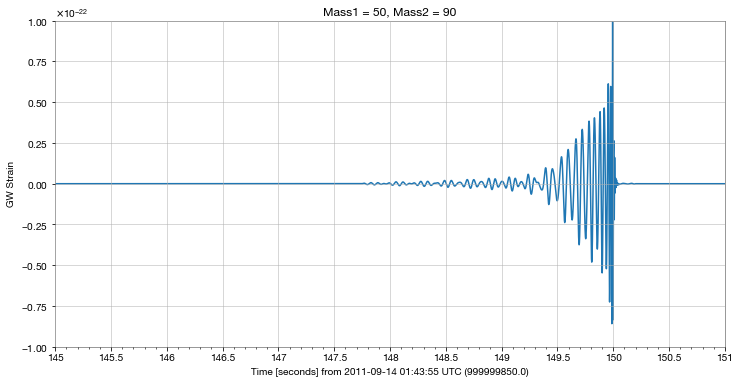

In [23]:
### Make the plot of signal strain vs time ###

# Time series data
dataL1 = TimeSeries.read(working_dir_full+'/signal_frames/event_0/L-fake_strain-999999850-300.gwf','L1:FAKE-STRAIN')
dataH1 = TimeSeries.read(working_dir_full+'/signal_frames/event_0/H-fake_strain-999999850-300.gwf','H1:FAKE-STRAIN')
dataV1 = TimeSeries.read(working_dir_full+'/signal_frames/event_0/V-fake_strain-999999850-300.gwf','V1:FAKE-STRAIN')

# Calculates auto-spectral density
# turns time series into frequency series
dataL1_spec = dataL1.asd()
dataH1_spec = dataH1.asd()
dataV1_spec = dataV1.asd()

# Create plot using GWPy
plot = Plot(dataL1) #,dataH1)
ax = plot.gca()

ax.set_epoch(999999850)
ax.set_xlim(999999850+145,999999850+151)
ax.set_ylim(-1e-22, 1e-22)
ax.set_title("Mass1 = {}, Mass2 = {}".format(mass1, mass2))
ax.set_ylabel('GW Strain')
#ax.set_ylabel(r'GW strain ASD [strain$/\sqrt{\mathrm{Hz}}$]')

plot.show()